In [93]:
using DataFrames

df = DataFrame(
    x = [1, 2, 3, 4, 5, 6, 7, 8],
    y = [1, 1, 1, 1, 0, 0, 0, 0]
)

Row,x,y
,Int64,Int64
1,1,1
2,2,1
3,3,1
4,4,1
5,5,0
6,6,0
7,7,0
8,8,0


In [94]:
using GLM

model = glm(@formula(y ~ x), df, Binomial(), LogitLink())
print(model)

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      z  Pr(>|z|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  143.123     11026.5    0.01    0.9896  -21468.4    21754.6
x            -31.8051     2435.34  -0.01    0.9896   -4804.99    4741.38
────────────────────────────────────────────────────────────────────────

In [95]:

import Pkg; Pkg.add("StatsFuns")
import StatsFuns: logistic

logistic(1)


   Resolving package versions...
  No Changes to `~/Code/bayesian-coursera-julia/Project.toml`
  No Changes to `~/Code/bayesian-coursera-julia/Manifest.toml`


0.7310585786300049

In [96]:
using Turing
using Distributions

@model function logistic_regression(x, y)
    α ~ Normal(0, 10)
    β ~ Normal(0, 10)
    
    ϕ = logistic.(α .+ β .* x)

    for i in eachindex(y)
        y[i] ~ Bernoulli(ϕ[i])
    end
end

turing_model = logistic_regression(df.x, df.y)

chains = sample(turing_model, NUTS(), 10000)

┌ Info: Found initial step size
└   ϵ = 1.6
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×16×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.07 seconds
Compute duration  = 1.07 seconds
parameters        = α, β
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


In [97]:
using StatsBase

mean(chains.value[iter=9000:end, var=[:α, :β], chain=1], dims=1)

2-dimensional AxisArray{Float64,2,...} with axes:
    :iter, 1:1:1
    :var, [:α, :β]
And data, a 1×2 Matrix{Float64}:
 13.4298  -3.11921

In [ ]:
predict(model, df)

8-element Vector{Union{Missing, Float64}}:
 1.0
 1.0
 1.0
 0.9999998759446539
 1.2405534615495686e-7
 1.9091788576461134e-21
 2.9381752349090766e-35
 4.521773157323084e-49

: 

In [68]:
predict_turing(x) = logistic(1497 - 336.582x)

predict_turing.(df.x) 

8-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.821012258598756e-81
 1.2150875230721452e-227
 0.0
 0.0

In [69]:
import RDatasets: dataset

ome_dataset = dataset("MASS", "OME")
ome_dataset = filter(row -> row.OME != "N/A", ome_dataset)
first(ome_dataset, 5)

Row,ID,Age,OME,Loud,Noise,Correct,Trials
,Int32,Int32,Cat…,Int32,Cat…,Int32,Int32
1,1,30,low,35,coherent,1,4
2,1,30,low,35,incoherent,4,5
3,1,30,low,40,coherent,0,3
4,1,30,low,40,incoherent,1,1
5,1,30,low,45,coherent,2,4


In [70]:
dat = copy(ome_dataset)
dat.Prob = dat.Correct ./ dat.Trials
dat.OMElow = ifelse.(dat.OME .== "low", 1, 0)
dat.NoiseCoherent = ifelse.(dat.Noise .== "coherent", 1, 0)
first(dat, 5)

Row,ID,Age,OME,Loud,Noise,Correct,Trials,Prob,OMElow,NoiseCoherent
,Int32,Int32,Cat…,Int32,Cat…,Int32,Int32,Float64,Int64,Int64
1,1,30,low,35,coherent,1,4,0.25,1,1
2,1,30,low,35,incoherent,4,5,0.8,1,0
3,1,30,low,40,coherent,0,3,0.0,1,1
4,1,30,low,40,incoherent,1,1,1.0,1,0
5,1,30,low,45,coherent,2,4,0.5,1,1


In [71]:
model = glm(@formula(Prob ~ Age + OMElow + Loud + NoiseCoherent), dat, Binomial(), LogitLink(), wts=dat.Trials)


StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Prob ~ 1 + Age + OMElow + Loud + NoiseCoherent

Coefficients:
──────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error       z  Pr(>|z|)  Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)    -5.71813   0.416159    -13.74    <1e-42  -6.53379   -4.90248
Age             0.018896  0.00376638    5.02    <1e-06   0.011514   0.026278
OMElow         -0.23715   0.123228     -1.92    0.0543  -0.478672   0.00437225
Loud            0.171682  0.00887631   19.34    <1e-82   0.154284   0.189079
NoiseCoherent  -1.5763    0.1152      -13.68    <1e-41  -1.80209   -1.35052
──────────────────────────────────────────────────────────────────────────────

In [72]:


# Assuming model is already defined and trained
# Example: model = glm(@formula(Y ~ age + OMElow + Loud + NoiseCoherent), data, Normal(), IdentityLink())

new_data = DataFrame(Age = [60], OMElow = [0], Loud = [60], NoiseCoherent = [1])
predict(model, new_data)


1-element Vector{Union{Missing, Float64}}:
 0.9843301191352406

In [73]:
first(dat, 5)

Row,ID,Age,OME,Loud,Noise,Correct,Trials,Prob,OMElow,NoiseCoherent
,Int32,Int32,Cat…,Int32,Cat…,Int32,Int32,Float64,Int64,Int64
1,1,30,low,35,coherent,1,4,0.25,1,1
2,1,30,low,35,incoherent,4,5,0.8,1,0
3,1,30,low,40,coherent,0,3,0.0,1,1
4,1,30,low,40,incoherent,1,1,1.0,1,0
5,1,30,low,45,coherent,2,4,0.5,1,1


In [74]:
import LinearAlgebra: dot
import Turing: Gibbs

@model function prob_regression(X, y)
    b0 ~ Normal(0, 5)
    b ~ filldist(Normal(0, 4), 4)

    ϕ = logistic.(b0 .+ dot.(b[1], X.Age) .+ dot.(b[2], X.OMElow) .+ dot.(b[3], X.Loud) .+ dot.(b[4], X.NoiseCoherent))

    for i in eachindex(y)
        y[i] ~ Binomial(X[i, :Trials], ϕ[i])
    end
end

t_model = prob_regression(dat[!, Not(:Prob, :Correct)], dat.Correct)

chains = sample(t_model, NUTS(), 10000)

┌ Info: Found initial step size
└   ϵ = 0.0015625
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:30


Chains MCMC chain (10000×19×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 35.74 seconds
Compute duration  = 35.74 seconds
parameters        = b0, b[1], b[2], b[3], b[4]
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


In [75]:
describe(chains)

Chains MCMC chain (10000×19×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 35.74 seconds
Compute duration  = 35.74 seconds
parameters        = b0, b[1], b[2], b[3], b[4]
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   ess_per_sec 
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64       Float64 

          b0    7.6077    0.0021    0.0005    20.9262    48.6192    2.1191        0.5856
        b[1]   -2.5128    0.0107    0.0024    20.6591    25.9094    2.1224        0.5781
        b[2]    4.2370    0.0005    0.0001    22.3762    27.8696    1.1709        0.6262
        b[3]    1.7786    0.0058    0.0013    20.6597   

In [76]:
coefficients = mean(chains.value[iter=:, var=[:b0, Symbol("b[1]"), Symbol("b[2]"), Symbol("b[3]"), Symbol("b[4]")], chain=1], dims=1)

2-dimensional AxisArray{Float64,2,...} with axes:
    :iter, 1:1:1
    :var, [:b0, Symbol("b[1]"), Symbol("b[2]"), Symbol("b[3]"), Symbol("b[4]")]
And data, a 1×5 Matrix{Float64}:
 7.60768  -2.51275  4.23696  1.77856  2.45249

In [77]:
import MCMCDiagnosticTools: rafterydiag

rl_diagnostic = rafterydiag(chains)
rl_diagnostic

1-element Vector{ChainDataFrame{@NamedTuple{parameters::Vector{Symbol}, thinning::Vector{Int64}, burnin::Vector{Float64}, total::Vector{Float64}, nmin::Vector{Int64}, dependencefactor::Vector{Float64}}}}:
 Raftery and Lewis diagnostic - Chain 1 (5 x 6)

In [78]:
mean(chains.value[iter=:, var=Symbol("b[2]"), chain=1] .> 0)

1.0

In [79]:
rhat_values = rhat(chains)
println("R-hat values:")
rhat_values

R-hat values:


R-hat
  parameters      rhat 
      Symbol   Float64 

          b0    2.1191
        b[1]    2.1224
        b[2]    1.1709
        b[3]    2.1224
        b[4]    1.4627


In [80]:
using LinearAlgebra
t = [1 2 3 4]

dot.(t, dat[!, [:Age, :OMElow, :Loud, :NoiseCoherent]])



Row,Age,OMElow,Loud,NoiseCoherent
,Int64,Int64,Int64,Int64
1,30,2,105,4
2,30,2,105,0
3,30,2,120,4
4,30,2,120,0
5,30,2,135,4
6,30,2,135,0
7,30,2,150,4
8,30,2,150,0
9,30,2,165,4


In [81]:
coefficients

2-dimensional AxisArray{Float64,2,...} with axes:
    :iter, 1:1:1
    :var, [:b0, Symbol("b[1]"), Symbol("b[2]"), Symbol("b[3]"), Symbol("b[4]")]
And data, a 1×5 Matrix{Float64}:
 7.60768  -2.51275  4.23696  1.77856  2.45249

In [82]:
using StatsFuns
logistic(dot(coefficients, [1, 60, 0, 50, 1]))

3.2630322271946167e-23

In [83]:
new_data = DataFrame(Age = [60], OMElow = [0], Loud = [50], NoiseCoherent = [1])
predict(model, new_data)

1-element Vector{Union{Missing, Float64}}:
 0.9185946785042409

In [84]:
pred = predict(model, dat[!, [:Age, :OMElow, :Loud, :NoiseCoherent]])


712-element Vector{Union{Missing, Float64}}:
 0.277709791150316
 0.650321632168988
 0.47565873506552653
 0.8144005624775434
 0.6815634658272446
 0.9119170314658119
 0.8347088412324839
 0.960671311669195
 0.922569555140418
 0.982944607822239
 0.40396514678030293
 0.7662637509495032
 0.615250666085056
 ⋮
 0.9379020642037303
 0.9864968403989319
 0.277709791150316
 0.650321632168988
 0.47565873506552653
 0.8144005624775434
 0.6815634658272446
 0.9119170314658119
 0.8347088412324839
 0.960671311669195
 0.922569555140418
 0.982944607822239

In [85]:
sum((dat.Prob .> 0.7 .&& pred .> 0.7) .|| (dat.Prob .< 0.7 .&& pred .< 0.7))

600

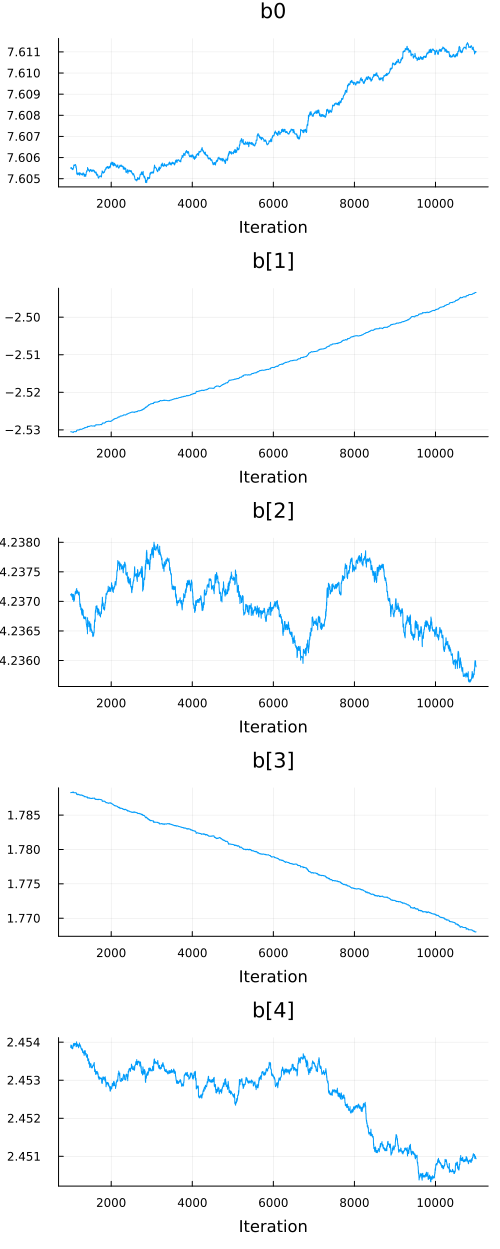

In [86]:
using StatsPlots

traceplot(chains)

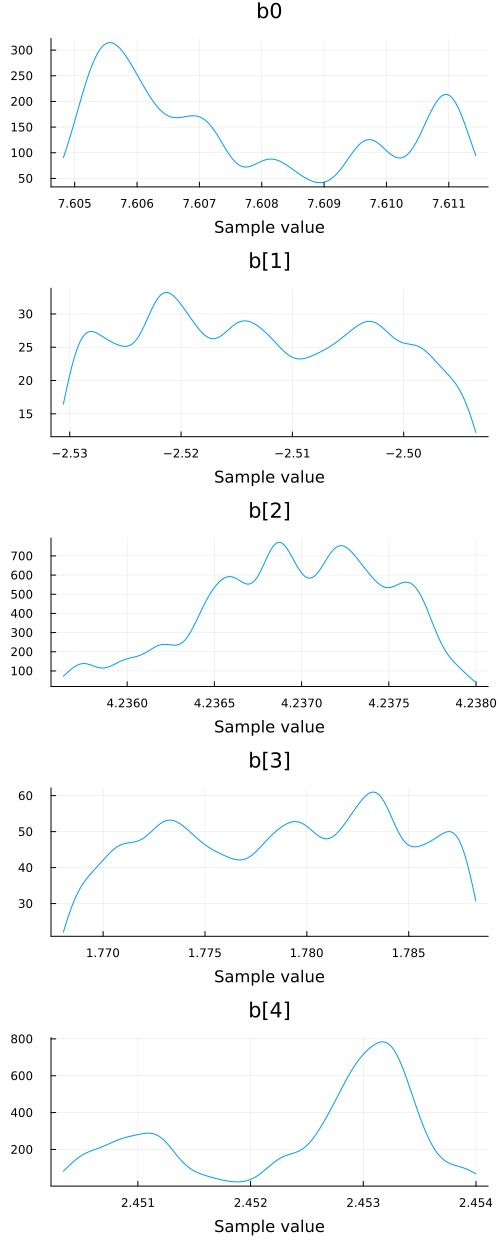

In [87]:
density(chains)

In [88]:
import Statistics: mean

function compute_DIC(chains, log_likelihood, parameter_names)
    # Extract samples for the parameters
    samples = Array(chains.value[:, parameter_names, 1])
    n_samples = size(samples, 1)

    # Compute deviance for each sample
    deviances = [-2 * log_likelihood(samples[i, :]) for i in 1:n_samples]
    mean_deviance = mean(deviances)

    # Compute deviance at the mean of the parameters
    mean_params = mean(samples, dims=1)
    deviance_at_mean = -2 * log_likelihood(vec(mean_params))

    # Compute DIC
    DIC = 2 * mean_deviance - deviance_at_mean
    return DIC, mean_deviance - deviance_at_mean
end

log_likelihood(params) = begin
    b0, b1, b2, b3, b4 = params
    ϕ = logistic.(b0 .+ b1 .* dat.Age .+ b2 .* dat.OMElow .+ b3 .* dat.Loud .+ b4 .* dat.NoiseCoherent)
    sum(logpdf.(Binomial.(dat.Trials, ϕ), dat.Correct))
end

compute_DIC(chains, log_likelihood, [:b0, Symbol("b[1]"), Symbol("b[2]"), Symbol("b[3]"), Symbol("b[4]")])

(110017.86719327171, 0.7196987356437603)